# Fraud transaction prediction

## Import library

In [2]:
import os
import calendar
import pathlib

import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

In [3]:
print("Scikit-learn version : {}".format(sklearn.__version__))

Scikit-learn version : 1.4.0


In [4]:
set_config(transform_output="pandas")
np.random.seed(99)

In [18]:
# function
def get_month_mapper():
    month_name_mapper = dict()

    for month_idx in range(1, 13):
        key = calendar.month_abbr[month_idx].upper()
        value = '{:02}'.format(month_idx)
        month_name_mapper[key] = value

    return month_name_mapper

def parse_tran_datetime(df):
    month_name_mapper = get_month_mapper()

    df = df.copy()

    df_datetime_extract = df['TRAN_DATETIME'].str.extract(pat=r'^(\d{2})([A-Z]{3})(\d{2}):(.+)')
    df_datetime_extract = df_datetime_extract.rename(columns={0: 'day', 1: 'month', 2: 'year', 3: 'time'})
    df_datetime_extract['month'] = df_datetime_extract['month'].map(month_name_mapper)
    df_datetime_extract['year'] = '20' + df_datetime_extract['year']

    df['TRAN_DATETIME'] = df_datetime_extract['year'] + \
                            '-' + \
                            df_datetime_extract['month'] + \
                            '-' + \
                            df_datetime_extract['day'] \
                            + ' ' + \
                            df_datetime_extract['time']

    return df

def check_sorted_txn_date(df):
    arr_bool_txn_date_sorted = df.groupby('CARD_NO')['TRAN_DATETIME'].is_monotonic_increasing
    bool_txn_date_sorted = arr_bool_txn_date_sorted.all(axis=0)
    
    return bool_txn_date_sorted

def prep_datetime_features(df):
    if not check_sorted_txn_date(df):
        df = df.sort_values(by=['CARD_NO', 'TRAN_DATETIME'])

    if df['TRAN_DATETIME'].dtypes != '<M8[ns]':
        df = parse_tran_datetime(df)
        df['TRAN_DATETIME'] = pd.to_datetime(df['TRAN_DATETIME'])

    if df['CUSTOMER_DOB'].dtypes != '<M8[ns]':
        df['CUSTOMER_DOB'] = pd.to_datetime(df['CUSTOMER_DOB'])
    
    df['tran_dom'] = df['TRAN_DATETIME'].dt.day
    df['tran_period'] = df['TRAN_DATETIME'].dt.hour // 6
    df['cust_age'] = ((df['TRAN_DATETIME'] - df['CUSTOMER_DOB']).dt.days / 365.25).astype(int)
    df['time_since_last_txn'] = df.groupby('CARD_NO')['TRAN_DATETIME'].diff().dt.total_seconds() // 3600

    return df

def prep_txn_features(df):
    df = df.sort_values(by=['CARD_NO', 'TRAN_DATETIME'])

    df['tran_month'] = df['TRAN_DATETIME'].dt.month

    df['txn_cnt_mtd'] = df.groupby(['CARD_NO', 'tran_month']).cumcount() + 1
    df['txn_amt_mtd'] = df.groupby(['CARD_NO', 'tran_month'])['TRAN_AMT'].cumsum()

    df['rolling_avg_amt'] = df.groupby('CARD_NO')['TRAN_AMT'].rolling(7, min_periods=1).mean().reset_index('CARD_NO', drop=True)
    df['rolling_avg_amt_ratio'] = df['TRAN_AMT'] / df['rolling_avg_amt']

    df['prev_txn_atm'] = df.groupby('CARD_NO')['TRAN_AMT'].shift(1)

    df.drop(columns='tran_month', inplace=True)

    return df

def fit_dummy_encoder(df, list_col_name):
    dummy_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
    dummy_encoder.fit(df[list_col_name])

    return dummy_encoder

def transform_dummy_encoder(df, list_col_name, dummy_encoder):
    arr_dummy = dummy_encoder.transform(df[list_col_name])
    col_name = dummy_encoder.get_feature_names_out(list_col_name)
    df_dummy = pd.DataFrame(arr_dummy, columns=col_name, index=df.index)

    return df_dummy

def prep_category_features(df, dummy_encoder=None):
    list_col_name = ['MERCHANT_NAME', 'MERCHANT_CATEGORY']

    if dummy_encoder is None:
        dummy_encoder = fit_dummy_encoder(df, list_col_name=list_col_name)

    df_prev = df.groupby('CARD_NO')[list_col_name].shift(1)

    df_dummy = transform_dummy_encoder(df, dummy_encoder=dummy_encoder, list_col_name=list_col_name)
    df_dummy_prev = transform_dummy_encoder(df_prev, dummy_encoder=dummy_encoder, list_col_name=list_col_name)
    
    list_col_name_prev = df_dummy_prev.columns + '_prev'
    df_dummy_prev = df_dummy_prev.rename(columns=dict(zip(df_dummy_prev.columns, list_col_name_prev)))
    
    df = pd.concat([df, df_dummy, df_dummy_prev], axis=1)
    df.loc[:, list_col_name_prev] = df.groupby('CARD_NO')[list_col_name_prev].rolling(7, min_periods=1).sum().reset_index('CARD_NO', drop=True)

    df.sort_index(inplace=True)

    return df, dummy_encoder

def initial_prep(df):
    df = prep_datetime_features(df)
    df = prep_txn_features(df)
    df, _ = prep_category_features(df)

    df['CUSTOMER_GENDER'] = df['CUSTOMER_GENDER'].map({'M': 0, 'F': 1})

    df_merchant_tier = df.groupby(['MERCHANT_NAME']).size().rename('merchant_n_txn').reset_index()
    df_merchant_tier['merchant_tier'] = np.where(df_merchant_tier['merchant_n_txn'].le(600), 0,
                                                np.where(df_merchant_tier['merchant_n_txn'].ge(950), 2, 1))
    df.merge(df_merchant_tier[['MERCHANT_NAME', 'merchant_tier']], left_on='MERCHANT_NAME', right_on='MERCHANT_NAME')

    df = df.drop(columns=['TRAN_DATETIME', 'CARD_NO', 'CUSTOMER_JOB', 'CUSTOMER_DOB', 'TRAN_NO', 'MERCHANT_NAME', 'MERCHANT_CATEGORY'])

    return df

def remove_correlate_features(df_corr, threshold=0.8, list_col_numeric=None, list_col_remove=list()):
    if list_col_numeric is None:
        list_col_numeric = df_corr.columns.tolist()
    
    col_name = list_col_numeric.pop(0)

    # check correlation
    list_col_compare = list(filter(lambda x: x != col_name, list_col_numeric))
    arr_corr_values = df_corr.loc[col_name, list_col_compare].abs()
    list_correlated_col = arr_corr_values[arr_corr_values > threshold].index.tolist()

    # update list remove col if correlated
    if len(list_correlated_col) > 0:
        for col in list_correlated_col:
            if col in list_col_numeric:
                list_col_numeric.remove(col)
            if col not in list_col_remove:
                list_col_remove.append(col)
    
    if len(list_col_numeric) > 1:
        remove_correlate_features(df_corr, threshold=threshold, list_col_numeric=list_col_numeric, list_col_remove=list_col_remove)
    
    return list_col_remove

def get_processor(df):
    list_transformer = list()

    cnt_nan = df.isnull().sum()
    list_col_name_nan = cnt_nan[cnt_nan > 0].index.tolist()
    imputer = SimpleImputer(strategy='constant', fill_value=0, missing_values=np.nan)
    list_transformer.append(('imputer', imputer, list_col_name_nan))

    df_corr = df.corr()
    list_col_corr = remove_correlate_features(df_corr)
    if len(list_col_corr) > 0:
        list_transformer.append(('correlated', 'drop', list_col_corr))
    
    transformer = ColumnTransformer(transformers=list_transformer, remainder='passthrough')

    scaler = RobustScaler(
        with_scaling=True, 
        quantile_range=(25.0, 75.0)
    )

    processor = Pipeline(steps=[('initial_prep', transformer), ('scaler', scaler)])
    processor.fit(df)

    return processor

def transform_features(df, processor):
    df_t = processor.transform(df)

    rename_col = df_t.columns.str.replace('imputer__|remainder__', '', regex=True)
    dict_rename_col = dict(zip(df_t.columns, rename_col))
    df_t.rename(columns=dict_rename_col, inplace=True)

    return df_t

def down_sampling(X, y, n_samples=40000):
    w_class_0 = np.where(y == 0)[0]
    w_class_1 = np.where(y == 1)[0]

    n_class_0 = len(w_class_0)
    n_class_1 = len(w_class_1)

    if n_samples is None:
        n_samples = n_class_1

    w_class_downsampled = np.random.choice(w_class_0, size=n_samples, replace=False)
    
    df_resample = pd.concat([X.iloc[w_class_downsampled], X.iloc[w_class_1]])
    y_resample = pd.concat([y.iloc[w_class_downsampled], y.iloc[w_class_1]])

    df_resample.sort_index(inplace=True)
    y_resample.sort_index(inplace=True)

    return df_resample, y_resample

def up_sampling(X, y, n_samples=40000):
    if n_samples is not None:
        n_majority = y.value_counts().max()
        sampling_strategy = n_samples / n_majority
    else:
        sampling_strategy = 'minority'
    
    sm = SMOTE(sampling_strategy=sampling_strategy, random_state=99)
    X_resample, y_resample = sm.fit_resample(X, y)

    return X_resample, y_resample

## Import data

In [6]:
# Handling the path(s) of the project. 
p = pathlib.Path(os.getcwd())

project_dir = str(p.parent)
path_data = str(p.parent.joinpath("data", "FraudDataset.csv"))

In [7]:
# import given fraud dataset
df = pd.read_csv(path_data)

# initial prep (for analysis)
df = parse_tran_datetime(df)
df['TRAN_DATETIME'] = pd.to_datetime(df['TRAN_DATETIME'])
df['CUSTOMER_DOB'] = pd.to_datetime(df['CUSTOMER_DOB'])

## Data exploration 

*<b>Q1</b>: How many rows and columns in the dataset?*

In [5]:
n_rows = df.shape[0]
n_cols = df.shape[1]

print("Number of rows in the dataset: {}".format(n_rows))
print("Number of columns in the dataset: {}".format(n_cols))

Number of rows in the dataset: 204759
Number of columns in the dataset: 10


*<b>Q2</b> : Explanation of data definition and its usage for business improvement*

In [6]:
df.head(5)

,TRAN_DATETIME,CARD_NO,MERCHANT_NAME,MERCHANT_CATEGORY,TRAN_AMT,CUSTOMER_GENDER,CUSTOMER_JOB,CUSTOMER_DOB,TRAN_NO,IS_FRAUD
0,2020-06-21 12:14:25,2291163933867244,KIRLIN AND SONS,PERSONAL_CARE,2.86,M,Mechanical engineer,1968-03-19,2DA90C7D74BD46A0CAF3777415B3EBD3,0
1,2020-06-21 12:14:33,3573030041201292,SPORER-KEEBLER,PERSONAL_CARE,29.84,F,"Sales professional, IT",1990-01-17,324CC204407E99F51B0D6CA0055005E7,0
2,2020-06-21 12:15:17,3526826139003047,JOHNSTON-CASPER,TRAVEL,3.19,M,Furniture designer,1955-07-06,57FF021BD3F328F8738BB535C302A31B,0
3,2020-06-21 12:15:50,3589289942931264,REICHEL LLC,PERSONAL_CARE,10.37,F,"Development worker, international aid",1972-03-05,8BE473AF4F05FC6146EA55ACE73E7CA2,0
4,2020-06-21 12:16:11,3546897637165774,KILBACK GROUP,FOOD_DINING,66.54,F,Barrister,1956-05-30,A7915132C7C4240996BA03A47F81E3BD,0


In [7]:
df.dtypes

TRAN_DATETIME        datetime64[ns]
CARD_NO                       int64
MERCHANT_NAME                object
MERCHANT_CATEGORY            object
TRAN_AMT                    float64
CUSTOMER_GENDER              object
CUSTOMER_JOB                 object
CUSTOMER_DOB         datetime64[ns]
TRAN_NO                      object
IS_FRAUD                      int64
dtype: object

<u>Data definition</u>

This data represents information about credit card transaction records, where merchant, transaction amount, and timestamp of transaction record are included, together with some predetermined dimensions of customer profile such as gender, job, and date of birth. These data could be used together to analyze for some predictive information that could refer to fraudulent credit card transaction.


<u>Data Usage</u>

This data can be used to 
 - analyze the insight of fraudulent credit card transactions
 - find some useful information that could be used to identify these fraudulent transactions
 - train predictive algorithm that could determine the possibility of credit card transaction being fraudulent


*<b>Q3</b>: Insight of the data and/or any hypotheses that could be concluded from the data*

- Exploration on target variable

In [8]:
df['IS_FRAUD'].value_counts()

IS_FRAUD
0    204374
1       385
Name: count, dtype: int64

In [9]:
100 * df['IS_FRAUD'].value_counts() / n_rows

IS_FRAUD
0    99.811974
1     0.188026
Name: count, dtype: float64

We have heavily imbalanced classes (approximate ratio of negative to positive observations is <b>530:1</b>)

- Exploration on <code>MERCHANT_NAME</code> column

In [10]:
df['MERCHANT_NAME'].nunique()

250

<Axes: >

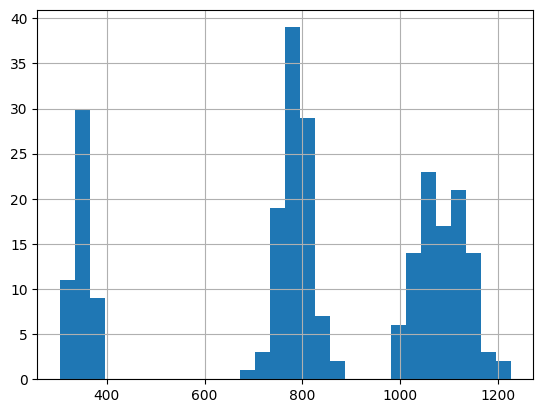

In [11]:
df['MERCHANT_NAME'].value_counts().hist(bins=30)

In [12]:
pd.crosstab(df['MERCHANT_NAME'], df['IS_FRAUD']).sort_values(by=[1, 0], ascending=[False, True]).head(20)

IS_FRAUD,0,1
MERCHANT_NAME,,
PARISIAN AND SONS,1193,9
CONROY-CRUICKSHANK,1111,8
"CHRISTIANSEN, GOYETTE AND SCHAMBERGER",1111,7
CUMMERATA-JONES,1117,7
"SCHILLER, BLANDA AND JOHNSON",1060,6
KUVALIS LTD,1052,5
"STROMAN, HUDSON AND ERDMAN",1103,5
HUELS-NOLAN,1116,5
HARBER INC,1120,5


- As we look at <code>MERCHANT_NAME</code> in terms of transaction volume, we can clearly see that *<b>there are 3 tiers of merchants</b>* that could be groupped together via
  - *<b>Gaussian Mixture Model (GMM)</b>* that could automatically group these merchants into 3 tiers
  - *Pre-determined thresholds* that separate those merchants into 3 tiers
- After look at top 20 merchants with highest numbers of fradulent transaction, we can conclude that *<b>most of them are in the 3rd tier (high transaction volume)</b>*. Therefore, grouping merchants by their transaction volume could be used to represents fraud transaction.

- Exploration on <code>MERCHANT_CATEGORY</code> column

In [13]:
100 * pd.crosstab(df['MERCHANT_CATEGORY'], df['IS_FRAUD'], normalize='index')

IS_FRAUD,0,1
MERCHANT_CATEGORY,,
FOOD_DINING,99.862483,0.137517
GAS_TRANSPORT,99.726805,0.273195
HOME,99.872003,0.127997
PERSONAL_CARE,99.822005,0.177995
TRAVEL,99.770761,0.229239


As we analyze <code>MERCHANT_CATEGORY</code> by using contingency table with target, we discovered that
 - Percentage of fradulent transactions in <code>"GAS_TRANSPORT"</code> and <code>"TRAVEL"</code> merchant types *<b>are higher than others (around 0.23% - 0.27%)</b>*
 - Percentage of fradulent transactions in <code>"HOME"</code> and <code>"FOOD_DINING"</code> merchant types *<b>are the lowest (around 0.13% - 0.17%)</b>*

Therefore, we can conclude that merchant category information could be useful for determining fraud transaction.

- Exploration on <code>TRAN_AMT</code> column

In [14]:
df.groupby('IS_FRAUD')['TRAN_AMT'].describe().T

IS_FRAUD,0,1
count,204374.000000,385.000000
mean,60.886524,72.412156
std,179.349856,95.178385
min,1.000000,1.780000
25%,17.790000,10.000000
50%,51.330000,19.260000
75%,73.440000,119.720000
max,22768.110000,422.310000


<Axes: >

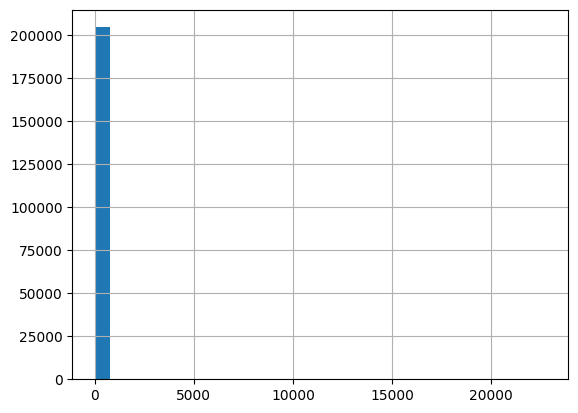

In [60]:
df['TRAN_AMT'].hist(bins=30)

From the analysis, it can be see that
 - Fraudulent transactions tend to involve with *<b>low transaction amount</b>*
 - There are *<b>some outliers in</b>* <code>TRAN_AMT</code> column

- Exploration on <code>CUSTOMER_GENDER</code> column

In [61]:
100 * pd.crosstab(df['CUSTOMER_GENDER'], df['IS_FRAUD'], normalize='index')

IS_FRAUD,0,1
CUSTOMER_GENDER,,
F,99.773412,0.226588
M,99.859033,0.140967


There is a differnt of *<b>fradulent transaction percentage between each gender</b>*

- Exploration on <code>CUSTOMER_JOB</code> column

In [69]:
df['CUSTOMER_JOB'].nunique()

477

In [68]:
pd.crosstab(df['CUSTOMER_JOB'], df['IS_FRAUD']).sort_values(by=1, ascending=False).head(20)

IS_FRAUD,0,1
CUSTOMER_JOB,,
Counsellor,903,9
Barrister,1056,8
Sub,927,8
Water engineer,936,8
Environmental consultant,1127,8
Comptroller,1117,7
Amenity horticulturist,610,7
Educational psychologist,779,7
Science writer,876,6


Information in <code>CUSTOMER_JOB</code> are in too much detail and no insight can be concluded from analysis --> drop this information

- Exploration on <code>CUSTOMER_DOB</code> column

In [15]:
filter_df_fraud = df['IS_FRAUD'].eq(1)
df['cust_age'] = ((df['TRAN_DATETIME'].max() - df['CUSTOMER_DOB']).dt.days / 365.25).astype(int)

df.loc[filter_df_fraud, 'cust_age'].describe()

count    385.000000
mean      46.940260
std       15.984989
min       18.000000
25%       35.000000
50%       45.000000
75%       58.000000
max       96.000000
Name: cust_age, dtype: float64

In [16]:
df.loc[~filter_df_fraud, 'cust_age'].describe()

count    204374.000000
mean         47.574961
std          17.728980
min          15.000000
25%          34.000000
50%          46.000000
75%          59.000000
max          96.000000
Name: cust_age, dtype: float64

In [33]:
df.drop(columns='cust_age', inplace=True)

There is no much differences in <code>cust_age</code>, but we'll keep it for feature selection

<u>Summary</u>: Sturcture and/or hypothesis about the data
 - The dataset is extremely imbalanced
 - Most of fraud transaction might occurred in merchants with high transaction volume
 - Fradulent transactions ocurred more often in <code>"GAS_TRANSPORT"</code> and <code>"TRAVEL"</code> merchant types
 - Fradulent transactions ocurred more often among women card holders
 - There are not much insights from customer occupation and age

## Feature Engineering

- Merchant name
- Last purchase merchant name (in last x transaction)
- Day of month //
- Time (or time period) //
- Time since last txn //
- Last purchase merchant category (in last x transaction)
- Last purchase amount
- Accumulated money spent (month) //
- Accumulated transaction count (month) //
- Rolling average transaction amount (in last x transaction)
- Current amount / rolling average

In [19]:
# initial prep
df = initial_prep(df)

c:\Users\11413929\AppData\Local\miniconda3\envs\r_atm_poc\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [20]:
# train-test split
X = df.drop(columns='IS_FRAUD')
y = df['IS_FRAUD']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99, stratify=y, test_size=0.3)

In [21]:
# transform data
processor = get_processor(X_train)

X_train = transform_features(X_train, processor)

In [22]:
# down sampling
X_train, y_train = down_sampling(X_train, y_train)

In [23]:
# up sampling
X_train, y_train = up_sampling(X_train, y_train)

## Feature Selection

*<b>Q4</b>: List of good predictors (along with explaination of methodology or framework on how to evaluate good predictor)*

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=99, test_size=0.3, stratify=y_train)

model_ = DecisionTreeClassifier(max_depth=None, random_state=99)
model_.fit(X_train, y_train)

r = permutation_importance(model_, X_val, y_val, n_repeats=16, random_state=99, scoring='recall', n_jobs=10)

r['feature_name'] = X_train.columns.values

In [28]:
n_features = 40
list_selected_features = list()

index = 1
for i in r.importances_mean.argsort()[::-1]:
    if (r.importances_mean[i] - 2 * r.importances_std[i] > 0):
        print(f"{index:<3}", f"{r.feature_name[i]:<80}", f"{r.importances_mean[i]:.3f} +/- {r.importances_std[i]:.3f}")
        if index < n_features - 1:
            list_selected_features.append(r.feature_name[i])
        index += 1

1   TRAN_AMT                                                                         0.483 +/- 0.005
2   tran_period                                                                      0.327 +/- 0.004
3   CUSTOMER_GENDER                                                                  0.123 +/- 0.003
4   MERCHANT_CATEGORY_PERSONAL_CARE                                                  0.093 +/- 0.002
5   rolling_avg_amt                                                                  0.075 +/- 0.002
6   rolling_avg_amt_ratio                                                            0.049 +/- 0.002
7   MERCHANT_CATEGORY_HOME                                                           0.039 +/- 0.002
8   MERCHANT_CATEGORY_GAS_TRANSPORT_prev                                             0.030 +/- 0.001
9   MERCHANT_CATEGORY_TRAVEL                                                         0.020 +/- 0.001
10  cust_age                                                                         0.018 

In [29]:
print("n features: {}".format(n_features))
print("selected features : {}".format(list_selected_features))

n features: 40
selected features : ['TRAN_AMT', 'tran_period', 'CUSTOMER_GENDER', 'MERCHANT_CATEGORY_PERSONAL_CARE', 'rolling_avg_amt', 'rolling_avg_amt_ratio', 'MERCHANT_CATEGORY_HOME', 'MERCHANT_CATEGORY_GAS_TRANSPORT_prev', 'MERCHANT_CATEGORY_TRAVEL', 'cust_age', 'txn_cnt_mtd', 'MERCHANT_NAME_KOSS AND SONS_prev', 'MERCHANT_NAME_STROMAN, HUDSON AND ERDMAN_prev', 'time_since_last_txn', 'MERCHANT_NAME_RUNTE-MOHR_prev', 'MERCHANT_NAME_FEIL, HILPERT AND KOSS_prev', 'MERCHANT_NAME_REINGER, WEISSNAT AND STROSIN_prev', 'MERCHANT_NAME_STREICH LTD_prev', 'MERCHANT_NAME_MORISSETTE-SCHAEFER_prev', 'MERCHANT_NAME_BERGE-ULLRICH_prev', 'MERCHANT_NAME_CRIST, JAKUBOWSKI AND LITTEL_prev', 'MERCHANT_NAME_EMARD INC_prev', 'MERCHANT_NAME_LUETTGEN PLC_prev', 'MERCHANT_NAME_TERRY LTD_prev', 'MERCHANT_NAME_REILLY LLC_prev', 'MERCHANT_NAME_SCHAEFER, MAGGIO AND DAUGHERTY_prev', 'MERCHANT_NAME_SCHNEIDER, HAYES AND NIKOLAUS_prev', 'MERCHANT_NAME_DAUGHERTY-THOMPSON_prev', 'MERCHANT_NAME_BARTOLETTI AND SONS_prev

From the permutation importance results, we can list top 10 most importance predictors below:
 - <code>TRAN_AMT</code> : transaction amount
 - <code>tran_period</code> : period of the time when transaction is made
 - <code>CUSTOMER_GENDER</code> : customer gender
 - <code>MERCHANT_CATEGORY_PERSONAL_CARE</code> : does the trasaction related to "PERSONAL_CARE" merchant category ??
 - <code>rolling_avg_amt</code> : average transaction amount in previous 7 consecutive transactions
 - <code>rolling_avg_amt_ratio</code> : ratio between transaction amount and its previous average
 - <code>MERCHANT_CATEGORY_HOME</code> : does the trasaction related to "HOME" merchant category ??
 - <code>MERCHANT_CATEGORY_GAS_TRANSPORT_prev</code> : do any of 7 previous trasactions related to "GAS_TRANSPORT" merchant category ??
 - <code>MERCHANT_CATEGORY_TRAVEL</code> : does the trasaction related to "TRAVEL" merchant category ??
 - <code>cust_age</code> : customer age

To evaluate good predictors, we can use permutation importance scores that measure the changes of pre-selected evaluation score when shuffle the data between rows (permutation). The methodology behind this score is if changes in particular predictor are big, predictive power of that particular variable is high since the permutation causes huge differences of model's performance

## Model Training

Experimentation Scope :
 - Algorithm :
    - Decision Tree Classifier
    - Random Forest Classifier
 - Evaluation Score : 
    - Recall score (Measures how well the model can capture the actual positive class (fraudulent transaction))
 - Methodology
    - Experiment on 2 algorithms
    - Select best algorithm (based on Validation set)
    - Evaluate performance for final accuracy (recall score)

- Decision Tree Classifier

In [51]:
# model training
model_v1 = DecisionTreeClassifier(max_depth=7, min_samples_leaf=1200)
model_v1.fit(X_train.loc[:, list_selected_features], y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=1200)

In [52]:
# model prediction
y_train_pred = model_v1.predict(X_train.loc[:, list_selected_features])
y_val_pred = model_v1.predict(X_val.loc[:, list_selected_features])

In [53]:
# model evaluation
recall_train = recall_score(y_train, y_train_pred)
recall_val = recall_score(y_val, y_val_pred)

print(f"recall score on training set : {recall_train:.3f}")
print(f"recall score on validation set : {recall_val:.3f}")

recall score on training set : 0.862
recall score on validation set : 0.863


- Random Forest Classifier

In [54]:
# model training
model_v2 = RandomForestClassifier(n_estimators=100, max_features="sqrt", max_depth=7, min_samples_leaf=1200)
model_v2.fit(X_train.loc[:, list_selected_features], y_train)

RandomForestClassifier(max_depth=7, min_samples_leaf=1200)

In [55]:
# model prediction
y_train_pred = model_v2.predict(X_train.loc[:, list_selected_features])
y_val_pred = model_v2.predict(X_val.loc[:, list_selected_features])

In [56]:
# model evaluation
recall_train = recall_score(y_train, y_train_pred)
recall_val = recall_score(y_val, y_val_pred)

print(f"recall score on training set : {recall_train:.3f}")
print(f"recall score on validation set : {recall_val:.3f}")

recall score on training set : 0.915
recall score on validation set : 0.916


Since second algorithm (Random Forest classifier) yields the best results on Validation Set, we will choose secind algorithm as our final model and re-evaluate the actual performance on Hold-out testing set

## Model Evaluation

In [57]:
# retrain model
X_train = pd.concat([X_train, X_val], axis=0)
y_train = pd.concat([y_train, y_val], axis=0)

model_v_final = RandomForestClassifier(n_estimators=100, max_features="sqrt", max_depth=7, min_samples_leaf=1200)
model_v_final.fit(X_train.loc[:, list_selected_features], y_train)

RandomForestClassifier(max_depth=7, min_samples_leaf=1200)

In [58]:
# prep X test
X_test = transform_features(X_test, processor)
X_test = X_test.loc[:, list_selected_features]

y_test_pred = model_v_final.predict(X_test)

In [71]:
recall_test = recall_score(y_test, y_test_pred)
c_matrix = confusion_matrix(y_test, y_test_pred)

print(f"recall score on testing set : {recall_test:.3f} ***")
print("confusion matrix :")
print(str(c_matrix).replace('[[', ' '*4 + '[[').replace('[ ', ' '*4 + '[ '))

recall score on testing set : 0.707 ***
confusion matrix :
    [[58735  2577]
     [   34    82]]


Final evaluation on model performance is <b>0.707</b> (recall)